In [1]:
from src.models.predictor import TrollPredictor
from src.models.trainer import TrollDetectorTrainer

predictor = TrollPredictor(
    model_path="./checkpoints/best_model_ru_only_enhanced_attention.pt",
    # model_name= 'distilbert-base-multilingual-cased',
    # adapter_path="./output/czech_comments_adapter/",
    # adapter_name="czech_comments_mlm",
    comments_per_user=20,
    max_length=96,
    threshold=0.5,
    use_adapter=False
)

INFO:adapters.heads.model_mixin:Adding head 'default' with config {'head_type': 'masked_lm', 'vocab_size': 119547, 'embedding_size': 768, 'layers': 2, 'activation_function': 'gelu', 'layer_norm': True, 'bias': True, 'shift_labels': False, 'label2id': None}.
INFO:src.models.predictor:Loaded model weights from ./checkpoints/best_model_ru_only_enhanced_attention.pt


In [2]:
from src.data_tools.czech_data_tools import load_czech_media_data
from pathlib import Path
import pandas as pd

DATA_DIR = Path('./data')
czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

INFO:src.data_tools.czech_data_tools:Found 124 JSON files to process
Loading files: 100%|██████████████████████████████████████████████████████████████████| 124/124 [00:10<00:00, 11.71it/s]


Loaded 845743 comments from 66588 unique authors


In [3]:
# Load your manual annotations
annotations_df = pd.read_csv("./annotations/user_labels.csv")

# Load comments data
# comments_df = pd.read_parquet("./data/processed/czech_media_comments.parquet")
comments_df = czech_comments

# Create a small fine-tuning dataset
def create_fewshot_dataset(annotations_df, comments_df):
    fewshot_data = []
    
    for _, row in annotations_df.iterrows():
        author_comments = comments_df[comments_df['author'] == row['author']]
        
        # label = 0.5 if row['label'] == -1 else row['label']
        if row['label'] == -1:
            continue
        
        fewshot_data.append({
            'author': row['author'],
            'text': author_comments['text'].tolist(),
            'label': row['label']  # 0 for not_troll, 1 for troll, 0.5 for uncertain
        })
    
    return fewshot_data

fewshot_data = create_fewshot_dataset(annotations_df, comments_df)
fewshot_df = pd.DataFrame(fewshot_data)

In [4]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from src.data_tools.dataset import collate_batch

# Create DataLoader for few-shot training
from torch.utils.data import Dataset, DataLoader

class FewShotDataset(Dataset):
    def __init__(
        self,
        data,
        tokenizer_name="distilbert-base-multilingual-cased",
        max_length=96,
        comments_per_user=10
    ):
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.comments_per_user = comments_per_user
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        comments = item['text']
        
        # Handle if we have more or fewer comments than needed
        if len(comments) > self.comments_per_user:
            comments = comments[:self.comments_per_user]
        elif len(comments) < self.comments_per_user:
            comments = comments + [comments[-1]] * (self.comments_per_user - len(comments))
            
        # Tokenize
        encodings = self.tokenizer(
            comments,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'label': torch.tensor(item['label'], dtype=torch.float),
            'author': item['author']
        }

# Create dataset and dataloader
fewshot_dataset = FewShotDataset(fewshot_data)
fewshot_loader = DataLoader(
    fewshot_dataset,
    batch_size=2,  
    shuffle=True,
    collate_fn=collate_batch  # Use your existing collate function
)

In [5]:
trainer = TrollDetectorTrainer(
    model=predictor.model,
    train_loader=fewshot_loader,
    val_loader=fewshot_loader,  # or a real validation loader if you split
    num_epochs=7,
    learning_rate=1e-5,
    checkpoint_dir="./checkpoints",
)

In [6]:
import torch

history = trainer.train()

torch.save(trainer.model.state_dict(), "./checkpoints/best_model_ru_only_finetuned_enhanced_attention.pt")

INFO:src.models.trainer:Starting training...
INFO:src.models.trainer:
Epoch 1/7
Evaluating: 100%|██████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 12.15it/s, loss=0.1602]
INFO:src.models.trainer:Train metrics: {'mse': 0.3076472372101113, 'rmse': 0.5546595687537639, 'mae': 0.3971123180559112, 'r2': -0.24597131070095068, 'binary_accuracy': 0.5833333333333334, 'loss': 0.9865733712083764}
INFO:src.models.trainer:Val metrics: {'mse': 0.21889647100553794, 'rmse': 0.46786373123542924, 'mae': 0.2928398135247537, 'r2': 0.11346929242757142, 'binary_accuracy': 0.75, 'loss': 0.7316860175795026}
INFO:src.models.trainer:Saved best model with R² score: 0.1135
INFO:src.models.trainer:
Epoch 2/7
Evaluating: 100%|██████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 13.65it/s, loss=1.2904]
INFO:src.models.trainer:Train metrics: {'mse': 0.1988332494373139, 'rmse': 0.4459072206606593, 'mae': 0.28991180192679167, 'r2': 0.19472533977887907, 'binary_acc


Best epoch: 7
Best validation metrics:
loss: 0.0257
mse: 0.0029
rmse: 0.0536
mae: 0.0241
r2: 0.9884
binary_accuracy: 1.0000


In [7]:
# Get authors with at least 10 comments
author_counts = comments_df['author'].value_counts()
eligible_authors = author_counts[author_counts >= 10].index

# Filter dataframe to only include those authors
filtered_comments_df = comments_df[comments_df['author'].isin(eligible_authors)]

# For each author, take max 50 comments
filtered_comments_df = filtered_comments_df.groupby('author').head(50)

# Print stats to verify
print(f"Original number of authors: {len(comments_df['author'].unique())}")
print(f"Number of authors with 10+ comments: {len(eligible_authors)}")
print(f"Original number of comments: {len(comments_df)}")
print(f"Number of comments after filtering: {len(filtered_comments_df)}")

# Assign back to comments_df
comments_df = filtered_comments_df

Original number of authors: 66588
Number of authors with 10+ comments: 16550
Original number of comments: 845743
Number of comments after filtering: 471535


In [8]:
import numpy as np

# Reduce to 50% of authors
author_counts = comments_df['author'].value_counts()
all_authors = author_counts.index
sample_size = int(len(all_authors))
sampled_authors = np.random.choice(all_authors, size=sample_size, replace=False)
comments_df = comments_df[comments_df['author'].isin(sampled_authors)]

print(f"Reduced to {len(comments_df)} comments from {sample_size} authors")

Reduced to 471535 comments from 16550 authors


In [22]:
# Read the predictions dataframe from CSV
# predictions_df_finetuned = pd.read_csv(Path('output') / 'czech_media_predictions_ru_only_finetuned_final.csv')


In [9]:
# Or make new predictions from comments if CSV not already pre-created
predictions_df_finetuned = predictor.predict_authors(comments_df)

100%|█████████████████████████████████████████████████████████████████████████████| 16550/16550 [44:12<00:00,  6.24it/s]


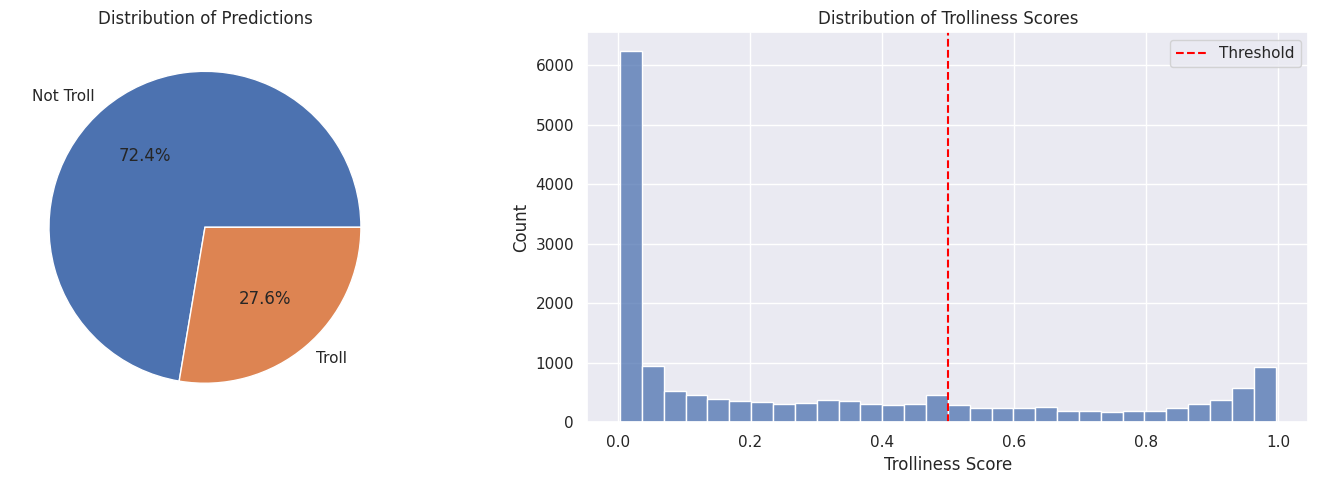


Trolliness Score Statistics:
----------------------------------------
count    16550.000000
mean         0.307592
std          0.341379
min          0.003332
25%          0.011617
50%          0.143427
75%          0.552652
max          0.995946
Name: trolliness_score, dtype: float64


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Pie chart of troll vs non-troll predictions
predictions = (predictions_df_finetuned['trolliness_score'] > predictor.threshold).map({True: 'Troll', False: 'Not Troll'})
prediction_counts = predictions.value_counts()

ax1.pie(prediction_counts, labels=prediction_counts.index, autopct='%1.1f%%')
ax1.set_title('Distribution of Predictions')

# Plot 2: Distribution of trolliness scores
sns.histplot(data=predictions_df_finetuned, x='trolliness_score', bins=30, ax=ax2)
ax2.axvline(x=predictor.threshold, color='red', linestyle='--', label='Threshold')
ax2.set_title('Distribution of Trolliness Scores')
ax2.set_xlabel('Trolliness Score')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTrolliness Score Statistics:")
print("-" * 40)
print(predictions_df_finetuned['trolliness_score'].describe())

In [11]:
# Load labeled authors from annotations file
labeled_authors_df = pd.read_csv('annotations/user_labels.csv')
labeled_authors = labeled_authors_df['author'].unique()

# Filter czech_comments to only include labeled authors
czech_comments_annotated = comments_df[comments_df['author'].isin(labeled_authors)]


In [13]:
from pathlib import Path

label_map = {'troll': 1, 'not_troll': 0}

# Get comment counts per author
author_comment_counts = comments_df['author'].value_counts()
authors_with_min_comments = author_comment_counts[author_comment_counts >= 5].index

# Get top 10 authors by trolliness score who have at least 5 comments
top_trolls_finetuned = predictions_df_finetuned[predictions_df_finetuned['author'].isin(authors_with_min_comments)].nlargest(10, 'trolliness_score')

# Save top trolls to CSV with just name, score and label (if available)
top_trolls_save = top_trolls_finetuned[['author', 'trolliness_score']].copy()
top_trolls_save['label'] = top_trolls_save['author'].map(
    labeled_authors_df.set_index('author')['label']
)
top_trolls_save.to_csv(Path('data') / 'top_trolls_finetuned_adapter.csv', index=False)

score_ranges = [(0, 0.1), (0.2, 0.3), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
for min_score, max_score in score_ranges:
    print(f"\nAuthors with scores {min_score:.1f}-{max_score:.1f}:")
    print("-" * 40)
    
    # Filter authors in this range with at least 5 comments
    filtered = predictions_df_finetuned[
        (predictions_df_finetuned['trolliness_score'] >= min_score) & 
        (predictions_df_finetuned['trolliness_score'] < max_score) &
        (predictions_df_finetuned['author'].isin(authors_with_min_comments))
    ]
    
    if len(filtered) == 0:
        print("No authors found in this range.")
        continue

    # Get up to 2 random authors
    range_authors = filtered.sample(n=min(2, len(filtered)))
    
    for _, author_row in range_authors.iterrows():
        author = author_row['author']
        score = author_row['trolliness_score']
        
        # Get label if available
        label = "Unlabeled"
        if author in labeled_authors_df['author'].values:
            label_val = labeled_authors_df[labeled_authors_df['author'] == author]['label'].iloc[0]
            label = label_map.get(label_val, "Unlabeled")
        
        print(f"\nAuthor: {author}")
        print(f"Trolliness Score: {score:.3f}")
        print(f"Manual Label: {label}")
        
        # Get 3 sample comments
        author_comments = comments_df[comments_df['author'] == author]['text'].head(5)
        print("\nSample Comments:")
        for i, comment in enumerate(author_comments, 1):
            print(f"\n{i}. {comment}")
        print("\n" + "-" * 40)


Authors with scores 0.0-0.1:
----------------------------------------

Author: Miroslav Zeman
Trolliness Score: 0.014
Manual Label: Unlabeled

Sample Comments:

1. Vyhostit!!!! A HNED!!!

2. Jen jestli titi rádoby turiste pochopí tuto výzvu.

3. Katar hrozí zastavením dodávek zkapalněného plynu Zelenskyj zase zastavením tranzitu plynu z ruska co na to přemoudřelá pekarová přijde zase se svetry nebo položí svou funkci a odejde do propadliště dějin spolu?

4. Rychetského paskvil rychle pochopili i ostatní béčkové strany bravo spolu to jste to zas domrvili

5. A že prodavačky s dětmi dělají celé dny víkendy svátky to poslancům nevadí a ještě jdou na ruku řetězcům když se projednává návrh na zavírací dobu o víkendech a svátcích a hlasují proti návrhu ?Všem kážou vodu a sami by pili víno ?Když úleva tak pro všechny!!!

----------------------------------------

Author: Vaclav Kucera
Trolliness Score: 0.011
Manual Label: Unlabeled

Sample Comments:

1. Zdeněk VeselýPane Bože tyto ruské propa

In [14]:
import json
# Save predictions with new columns
predictions_df_finetuned.to_csv(Path('output') / 'czech_media_predictions_finetuned_ru_only_enhanced_attention.csv', index=False)

# Update the summary statistics to include regression metrics
summary_stats = {
    'total_authors': len(predictions_df_finetuned),
    'mean_trolliness': predictions_df_finetuned['trolliness_score'].mean(),
    'median_trolliness': predictions_df_finetuned['trolliness_score'].median(),
    'std_trolliness': predictions_df_finetuned['trolliness_score'].std(),
    'troll_percentage': (predictions_df_finetuned['binary_prediction'] == 'troll').mean() * 100,
    'mean_confidence': predictions_df_finetuned['binary_confidence'].mean(),
    'threshold_used': predictor.threshold
}

# Save summary
with open(Path('output') / 'prediction_summary_enhanced_attention.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

In [ ]:
from src.analysis.user_analysis import analyze_user_predictions, format_analysis_results

# Example usage:
username = "Petr Taročko"  # Patr Tarocko docela troll
analysis_results = analyze_user_predictions(
    username=username,
    predictions_df=predictions_df_finetuned,
    comments_df=comments_df,
    predictor=predictor
)

# Print formatted results
print(format_analysis_results(analysis_results))




Analysis for user: Petr Taročko
------------------------------------------------------------
Predicted Label: troll
Trolliness Score: 0.962
Prediction Confidence: 0.462
------------------------------------------------------------

Comment Analysis (with attention weights):
------------------------------------------------------------

Comment 1:
Text: Ať si je nechají. Hnus.
Attention weight: 0.021
----------------------------------------

Comment 2:
Text: Hurá. Hl. Zdraví
Attention weight: 0.021
----------------------------------------

Comment 3:
Text: Zase se něco povedlo. Jen tak dál.
Attention weight: 0.141
----------------------------------------

Comment 4:
Text: Je to k ničemu. Klidně to zrušte. Nikdo. Se na to nedívá
Attention weight: 0.013
----------------------------------------

Comment 5:
Text: Lipavský je tvrdý chlap. Jen do toho hochu.
Attention weight: 0.032
----------------------------------------

Comment 6:
Text: Konečně bude první. Fiala!
Attention weight: 0.134
---

In [17]:
# Example usage:
username = "Zuzana Krausová"#"Jindra Macek" # #"Ivo Jiroušek" #Gabriela Horáčková" 
analysis_results = analyze_user_predictions(
    username=username,
    predictions_df=predictions_df_finetuned,
    comments_df=comments_df,
    predictor=predictor
)
# Print formatted results
print(format_analysis_results(analysis_results))


Analysis for user: Zuzana Krausová
------------------------------------------------------------
Predicted Label: non-troll
Trolliness Score: 0.007
Prediction Confidence: 0.493
------------------------------------------------------------

Comment Analysis (with attention weights):
------------------------------------------------------------

Comment 1:
Text: Evidentně rakouský stát vytváří pro mladé rodiny tak fantastické podmínky, že se jim nechce přivádět na svět děti. Takže vítězí a proto procenta jazykové negramotnosti stoupají. Já tam ani nejezdím na dovolenou, protože potkat v restauraci nebo kavárně v turistických oblastech v obsluze Rakušáka - to je docela rarita. Někam zmizli.Jsou tam vůbec ještě nějací?Ani se nedivím, že ta jejich ex ministryně Kneisslová odešla do Ruska. Ono tam fakt asi bude líp.
Attention weight: 0.044
----------------------------------------

Comment 2:
Text: Tomáš SmítalCožpak kdyby někdo pomocí umělé inteligence dal na FB vás, nahého s tak směšným bumbr

In [23]:
predictor_comparison = TrollPredictor(
    model_path="./checkpoints/finetuned_model_13_05.pt",
    # model_name= 'distilbert-base-multilingual-cased',
    # adapter_path="./output/czech_comments_adapter/",
    # adapter_name="czech_comments_mlm",
    comments_per_user=10,
    max_length=96,
    threshold=0.5,
    use_adapter=False
)

INFO:adapters.heads.model_mixin:Adding head 'default' with config {'head_type': 'masked_lm', 'vocab_size': 119547, 'embedding_size': 768, 'layers': 2, 'activation_function': 'gelu', 'layer_norm': True, 'bias': True, 'shift_labels': False, 'label2id': None}.
INFO:src.models.predictor:Loaded model weights from ./checkpoints/finetuned_model_13_05.pt


In [25]:
username = "David Vápeník"#"Jindra Macek" # #"Ivo Jiroušek" #Gabriela Horáčková" 
analyze_user_predictions(
    username=username,
    predictions_df=predictions_df_finetuned,
    comments_df=comments_df,
    predictor=predictor_comparison
)


Analysis for user: David Vápeník
------------------------------------------------------------
Predicted Label: not_troll
Trolliness Score: 0.434
Prediction Confidence: 0.133
------------------------------------------------------------

Comment Analysis (with attention weights):
------------------------------------------------------------

Comment 1:
Text: Konečně, vynikajicí rozhodnutí palec hore. Ted se muže konečně ukázat jak to funguje a jde když je opravdu ,člověk v tísni’ klíště odtáhne když nemá kde sát
Attention weight: 0.122
----------------------------------------

Comment 2:
Text: V Praze ? A to někoho překvapuje? A to nenapadl sníh, to pak bude teprve veselo
Attention weight: 0.001
----------------------------------------

Comment 3:
Text: Tak jistě, nikdo nechce do války západních mocností a ruska probíhajících na území Ukrajiny. A hlavně ti co jsou boje schopní se flákají u nás nebo v Polsku. A sají sociální programy EU a daných zemí
Attention weight: 0.191
--------------